# steps

## 1. collect (unprocessed) data [???]

## 2 process data [k8s, spark, ???]
- build processing model
- e.g crop, scale, cut ... etc...

## 3. move processed date in understandable directory structure [k8s, s3]

## 4. load data (based on expected dir structure) [python]

## 5. build model [python]

## 6. train model [k8s, python]

## 6.1 evaluate model [included in training]
-> repeat 1 or 2 or 5
-> repeat 6, 7

## 8 (on success) deploy model ??? (pipeline) [CI/CD, k8s]

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [2]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [3]:

def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [4]:

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [5]:

log_interval = 64;
batch_size = 64;
test_batch_size = 64;

use_cuda = False; #not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(1); #args.seed
device = torch.device("cuda" if use_cuda else "cpu");
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {};

lr = 0.01;
momentum = 0.5;


In [6]:

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs
)


In [7]:

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs
)


In [8]:

model = Net().to(device);
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum);


In [9]:

epochs = 3
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300039
Train Epoch: 1 [4096/60000 (7%)]	Loss: 1.008566
Train Epoch: 1 [8192/60000 (14%)]	Loss: 0.320956
Train Epoch: 1 [12288/60000 (20%)]	Loss: 0.242414
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.404084
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.189783
Train Epoch: 1 [24576/60000 (41%)]	Loss: 0.195753
Train Epoch: 1 [28672/60000 (48%)]	Loss: 0.216293
Train Epoch: 1 [32768/60000 (55%)]	Loss: 0.238474
Train Epoch: 1 [36864/60000 (61%)]	Loss: 0.218672
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.176704
Train Epoch: 1 [45056/60000 (75%)]	Loss: 0.148675
Train Epoch: 1 [49152/60000 (82%)]	Loss: 0.188559
Train Epoch: 1 [53248/60000 (89%)]	Loss: 0.084541
Train Epoch: 1 [57344/60000 (96%)]	Loss: 0.086281

Test set: Average loss: 0.1012, Accuracy: 9665/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.145885
Train Epoch: 2 [4096/60000 (7%)]	Loss: 0.043596
Train Epoch: 2 [8192/60000 (14%)]	Loss: 0.136309
Train Epoch: 2 [12288/60000 (20%)]	Loss: 0.044008
Train

In [26]:
test_data_loader_index = 3

single_loaded_img = test_loader.dataset.data[test_data_loader_index]
#print(single_loaded_img)
single_loaded_img = single_loaded_img.to(device)
single_loaded_img = single_loaded_img[None, None]
#single_loaded_img = single_loaded_img.type('torch.DoubleTensor')
single_loaded_img = single_loaded_img.type('torch.FloatTensor')


#single_loaded_img = Variable(single_loaded_img) #depricated
#print(single_loaded_img)
raw_prediction = model(single_loaded_img)
print("raw_prediction:")
print(raw_prediction)
print("")


maxed_prediction = raw_prediction.max(1, keepdim=True)[1]
print("maxed_prediction:")
print(maxed_prediction.item())
print("")


def predict_image(image):
    image_tensor = image.unsqueeze_(0)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    #return output
    #index = output.data.cpu().numpy().argmax()
    #return index

#out_predict = model(single_loaded_img)

#out_predict = predict_image(single_loaded_img)


raw_prediction:
tensor([[    0.0000, -1607.3492, -1034.7665, -1385.7178, -1543.7114, -1284.3535,
          -864.5186, -1399.4502, -1316.4189, -1010.5676]],
       grad_fn=<LogSoftmaxBackward>)

maxed_prediction:
0



In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

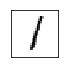

In [25]:
def plot_image(image):
    "Plot a MNIST image."
    fig = plt.figure()
    ax = fig.add_subplot(4, 1, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

plot_image(test_loader.dataset.data[test_data_loader_index])